In [1]:
# Import relevant python packages.
import pandas as pd # For working with Pandas dataframes.
import numpy as np # For working with arrays.
import seaborn as sns # For data visualisation on top of Matplotlib.
import matplotlib.pyplot as plt # For data visualisation. 
import matplotlib as mpl # For data visualisation. 
import itertools 
import os
from scipy.stats import sem # For calculation of standard error. 
from matplotlib import rc
from matplotlib.pyplot import Line2D
import pingouin as pg # For initial statistical comparisons.
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) # Initial plot formatting. 
mpl.rcParams['pdf.fonttype'] = 42 # Initial plot formatting.

### Setting the directory

In [101]:
# Absolute path to the relevant directory
PATH_WIN = 'C:/Users/dylan/Documents/VGLUT2_check/' # To replicate, change to your own path or RDM path, if applicable.
PATH_MAC = '/Users/uqdkilpa/Documents/Code/Custom_Scripts/histology-analyses/Suarez-VGLUT2-2023/'
os.chdir(PATH_MAC) # Change current wd to PATH

### Helper functions

In [102]:
# Helper functions 

def normalise_values(values):
    '''
    A simple function for performing min-max normalisation on a list of grey values extracted from ImageJ's 'Plot Profile' plugin. 

    :param values: array or list of values to be min-max normalised.
    :return: the normalised values.
    
    '''
    return [(i - min(values))/(max(values)-min(values)) for i in values]

# def interpolate(inp,fi): 
#     '''
#     Function to perform a linear interpolation to a pre-specified length, e.g., the largest length array present in set of samples.

#     :param inp: list/array of values to be interpolated. 
#     :param fi: the fractional index
#     :return: the interpolated value

#     '''
#     fi = min(fi, len(inp) - 1) # Ensure that the fractional index is not greater than the length of the array.
#     i, f = int(fi//1), fi % 1
#     j = i + 1 if f > 0 else i
#     return (1-f) * inp[i] + f * inp[j]

# Cleaner implementation of the above function
def interpolate(inp, new_len):
    '''
    Function to perform a linear interpolation to a specified length.

    :param inp: list/array of values to be interpolated.
    :param new_len: the final size of the interpolated array
    :return: the interpolated array
    '''
    # Calculate the scaling factor to map the original indices to the new indices
    scaling_factor = (len(inp) - 1) / (new_len - 1) # Needs to be -1 to account for python indexing.

    # Create a new list to store the interpolated values
    interpolated_array = []

    # Iterate through the new list and calculate the interpolated values
    for i in range(new_len):
        # Calculate the corresponding fractional index in the original list
        fractional_index = i * scaling_factor

        # Limit the fractional index to be within the valid range of indices in the input list
        fractional_index = min(fractional_index, len(inp) - 1 - 1e-9)

        # Break the fractional index into its integer part and fractional part
        integer_part, fractional_part = int(fractional_index // 1), fractional_index % 1

        # Determine the next index in the input list
        next_index = integer_part + 1 if fractional_part > 0 else integer_part

        # Calculate the interpolated value using a weighted average of the values at the integer part and next index
        interpolated_value = (1 - fractional_part) * inp[integer_part] + fractional_part * inp[next_index]

        # Append the interpolated value to the new list
        interpolated_array.append(interpolated_value)

    return interpolated_array

# def mean_of_middle_20_percent(values):
#     """
#     Calculate the mean of the middle 20% of values in a list or array.

#     :param values: list or array of values.
#     :return mean: the mean of the middle 20% of values.
#     :raises TypeError: if `values` is not a list or array.

#     """
#     # Ensure that the input is a list or array
#     if not isinstance(values, (list, np.ndarray,pd.Series)):
#         raise TypeError("Input must be a list, array, or pd.Series.")
    
#     # Convert the input to a list if it is an array
#     if isinstance(values, pd.Series):
#         values = values.tolist()

#     # Get the length of the input and find the index of the first and last values in the middle 20%
#     n = len(values)
#     start_index = int(0.4 * n)
#     end_index = int(0.6 * n)

#     # Get the middle 20% of values
#     middle_values = values[start_index:end_index] # keep in mind python indexing is exclusive of the last index.

#     # Calculate and return the mean of the middle values
#     return sum(middle_values) / len(middle_values)


def mean_of_middle_n_percent(values, n_percent=20):
    """
    Calculate the mean of the middle N% of values in a list or array.

    :param values: list or array of values.
    :param n_percent: percentage of values to consider as the middle portion (default is 20%).
    :return mean: the mean of the middle N% of values.
    :raises TypeError: if `values` is not a list or array.
    :raises ValueError: if `n_percent` is not between 0 and 100.

    """
    # Ensure that the input is a list or array
    if not isinstance(values, (list, np.ndarray, pd.Series)):
        raise TypeError("Input must be a list, array, or pd.Series.")

    # Check that n_percent is valid
    if n_percent < 0 or n_percent > 100:
        raise ValueError("n_percent must be between 0 and 100.")
    
    # Convert the input to a list if it is an array
    if isinstance(values, pd.Series):
        values = values.tolist()

    # Get the length of the input and find the index of the first and last values in the middle N%
    n = len(values)
    start_index = int(((100 - n_percent) / 2) * n / 100)
    end_index = int((100 - (100 - n_percent) / 2) * n / 100)

    # Get the middle N% of values
    middle_values = values[start_index:end_index] # keep in mind python indexing is exclusive of the last index.

    # Calculate and return the mean of the middle values
    return sum(middle_values) / len(middle_values)



def get_intervals(data, markers):
    """
    Calculate the intervals that each value in a list, array, or Pandas Series belongs to, based on a list, array, or Pandas Series of markers.

    :params data: list, array, or Pandas Series of data values.
    :params markers: list, array, or Pandas Series of markers that define the intervals.
    :return intervals: list of interval labels (strings), one for each value in `data`.
    :raises TypeError: if `data` or `markers` is not a list, array, or Pandas Series.

    """
    # Ensure that the input is a list, array, or Pandas Series
    if not isinstance(data, (list, np.ndarray, pd.Series)):
        raise TypeError("Input data must be a list, array, or Pandas Series.")
    if not isinstance(markers, (list, np.ndarray, pd.Series)):
        raise TypeError("Input markers must be a list, array, or Pandas Series.")

    # Convert the input data and markers to lists if they are arrays or Pandas Series
    if isinstance(data, np.ndarray):
        data = data.tolist()
    if isinstance(data, pd.Series):
        data = data.tolist()
    if isinstance(markers, np.ndarray):
        markers = markers.tolist()
    if isinstance(markers, pd.Series):
        markers = markers.tolist()

    # Initialize an empty list to store the intervals
    intervals = []

    # Iterate over the data values and determine the interval for each value
    for v in data:
        if v >= markers[0] and v < markers[1]:
            intervals.append('Interval 1')
        elif v >= markers[1] and v < markers[2]:
            intervals.append('Interval 2')
        elif v >= markers[2] and v < markers[3]:
            intervals.append('Interval 3')
        elif v >= markers[3] and v < markers[4]:
            intervals.append('Interval 4')
        elif v >= markers[4] and v < markers[5]:
            intervals.append('Interval 5')
        elif v >= markers[5] and v <= markers[6]:
            intervals.append('Interval 6')

    return intervals

### Select stage and region for layer marker calibration

In [112]:
# Layer positions are examined stage-by-stage.
layer_markers = pd.read_excel("./PNAS_VGluT2_Final.xlsx",sheet_name=0) # reloads the sheet (not super necessary), selects the 2nd tab.  
stage = 23.0 # identifies the stage of interest
subset_layer_markers = layer_markers[layer_markers['STAGE']==stage] # subset the layer markers to the stage of interest.
subset_layer_markers.head() # check that it worked.

,ID,AGE_PN,STAGE,AREA,SIDE,UNIQUE_ID,Y,Position
0,1294a,21,23,SS,R,1294a23SSR,350.395,1
1,1294a,21,23,SS,R,1294a23SSR,380.555,2
2,1294a,21,23,SS,R,1294a23SSR,409.726,3
3,1294a,21,23,SS,R,1294a23SSR,461.147,4
4,1294a,21,23,SS,R,1294a23SSR,475.980,5


In [113]:
# Normalises the layers to the range 0-1.
# Based on one bilateral representative sample from each stage (L and R values averaged).
normed_markers = []
for i in subset_layer_markers.groupby("UNIQUE_ID"): # groups the data by UNIQUE_ID
    df = i[1] # selects the data for each UNIQUE_ID
    layer_values = df['Y'].tolist() # selects the Y values for each UNIQUE_ID
    norm_layer_values = normalise_values(layer_values) # normalises the Y values for each UNIQUE_ID
    norm_layer_values = [round(v,3) for v in norm_layer_values] # rounds the values to 3 decimal places
    normed_markers.append(norm_layer_values) # appends the normalised values to the list

# Calculate the mean layer markers for each stage.
mean_position = lambda normed_markers: [round(sum(positions) / len(positions), 3) for positions in zip(*normed_markers)]
mean_normed_markers = mean_position(normed_markers)

print(f'The individual layer markers for stage {stage} are: {normed_markers}\n')
print(f'The mean layer markers for stage {stage} are: {mean_normed_markers}')

The individual layer markers for stage 23.0 are: [[0.0, 0.111, 0.23, 0.48, 0.565, 0.71, 1.0], [0.0, 0.125, 0.246, 0.46, 0.522, 0.626, 1.0], [0.0, 0.084, 0.218, 0.36, 0.457, 0.575, 1.0], [0.0, 0.097, 0.236, 0.407, 0.521, 0.638, 1.0]]

The mean layer markers for stage 23.0 are: [0.0, 0.104, 0.232, 0.427, 0.516, 0.637, 1.0]


### Load in raw data sheets

In [106]:
# load in all grey values
grey_values = pd.read_excel("./PNAS_VGluT2_Final.xlsx",sheet_name=1)
grey_values.head()

,ID,AGE_PN,STAGE,AREA,SIDE,UNIQUE_ID,SAMPLE_ID,Distance_microns,VGLUT2,SATB2,DAPI,Experimenter
0,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.000,631.453,874.802,1107.635,TB
1,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.454,649.632,893.142,1110.610,TB
2,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.908,666.433,913.247,1115.590,TB
3,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,1.362,683.220,932.810,1129.680,TB
4,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,1.816,700.702,951.333,1149.838,TB


### Select stage and region to interpolate

In [114]:
# Select stage of interest for interpolation.
# Make sure that the stage matches the stage of the layer markers.
df_interpolation = grey_values[grey_values['STAGE']==23.0] # the excel file is a bit messy, with some of my sections along with Toby's, hence keep the first 4 stages to Toby's data.
df_interpolation

,ID,AGE_PN,STAGE,AREA,SIDE,UNIQUE_ID,SAMPLE_ID,Distance_microns,VGLUT2,SATB2,DAPI,Experimenter
0,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.000,631.453,874.802,1107.635,TB
1,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.454,649.632,893.142,1110.610,TB
2,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,0.908,666.433,913.247,1115.590,TB
3,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,1.362,683.220,932.810,1129.680,TB
4,1182A,23.0,23,SS,L,1182AP23S23SSLTB,1182AP23S23SS,1.816,700.702,951.333,1149.838,TB
...,...,...,...,...,...,...,...,...,...,...,...,...
8600,1182C,23.0,23,VIS,R,1182CP23S23VISRTB,1182CP23S23VIS,312.352,550.760,596.770,2018.043,TB
8601,1182C,23.0,23,VIS,R,1182CP23S23VISRTB,1182CP23S23VIS,312.806,556.837,602.437,2003.405,TB
8602,1182C,23.0,23,VIS,R,1182CP23S23VISRTB,1182CP23S23VIS,313.260,564.778,611.400,1994.297,TB
8603,1182C,23.0,23,VIS,R,1182CP23S23VISRTB,1182CP23S23VIS,313.714,574.420,621.750,1990.978,TB


### Interpolate dataframe
Starts by finding the maximum cortical width within a stage.

In [115]:
# Find the maximum cortical width by which all others will be adjusted (stage-by-stage).
array_lens = [] # Contains the lengths of each cortical width.
for a in df_interpolation.groupby('UNIQUE_ID'): # Iterate through each animal.
    data = a[1] # Contains the data for that animal.
    array_lens.append(len(data['VGLUT2'])) # Append the length of the cortical width in for that animal.
max_array_len = max(array_lens) # Contains the maximum cortical width in by which all others will be adjusted.
print(max_array_len)

956


Now interpolate

In [99]:
# # Interpolate the cortical width in um to the maximum length.
# interpolated_dict = {'ID':[],'Sample_ID':[],'Area':[],'Distance':[],'norm_Distance':[],'VGLUT2':[]} # To contain the interpolated data.
# for a in df_interpolation.groupby('UNIQUE_ID'): # Iterate through each animal.
#     distance = 0 # Reset the distance counter.
#     name = a[0] # Contains the name of the animal.
#     data = a[1] # Contains the data for that animal.
#     samp_id = data['SAMPLE_ID'].values[0] # Contains the sample ID.
#     area = data['AREA'].values[0] # Contains the area (i.e., SS or VIS).
#     inp_vglut2 = data['VGLUT2'].values # Contains the VGLUT2 values.
#     new_len = max_array_len # Contains the maximum cortical width in um by which all others will be adjusted.
#     delta_vglut2 = (len(inp_vglut2)-1) / (new_len-1) # Contains the delta for the interpolation. This is essentially a scaling factor.
#     for i in range(new_len): # Iterate through the new length.
#         v_vglut2 = round(interpolate(inp_vglut2, i*delta_vglut2),3) # Interpolate the VGLUT2 values.
#         interpolated_dict['VGLUT2'].append(v_vglut2) # Append the interpolated VGLUT2 values.
#         interpolated_dict['ID'].append(name) # Append the animal ID.
#         interpolated_dict['Area'].append(area) # Append the area.
#         interpolated_dict['Distance'].append(distance) # Append the distance.
#         interpolated_dict['Sample_ID'].append(samp_id) # Append the sample ID.
#         distance += 1 # Increment the distance counter.
#     norm_distance = normalise_values(interpolated_dict['Distance']) # Normalise the distance values.
#     interpolated_dict.update({'norm_Distance': norm_distance}) # Update the dictionary with the normalised distance values.
# min_max = normalise_values(interpolated_dict['VGLUT2']) # Normalise the VGLUT2 values.
# interpolated_dict.update({'min-max_VGLUT2':min_max}) # Update the dictionary with the normalised VGLUT2 values.
# interpolated_df = pd.DataFrame(interpolated_dict) # Convert the dictionary to a Pandas DataFrame.
# interpolated_df # Check that it worked.

In [116]:
# To work with the updated, clearer interpolation function. 
# Interpolate the cortical width in um to the maximum length.
interpolated_dict = {'ID':[],'Sample_ID':[],'Area':[],'Distance':[],'norm_Distance':[],'VGLUT2':[]} # To contain the interpolated data.
for a in df_interpolation.groupby('UNIQUE_ID'): # Iterate through each animal.
    distance = 0 # Reset the distance counter.
    name = a[0] # Contains the name of the animal.
    data = a[1] # Contains the data for that animal.
    samp_id = data['SAMPLE_ID'].values[0] # Contains the sample ID.
    area = data['AREA'].values[0] # Contains the area (i.e., SS or VIS).
    inp_vglut2 = data['VGLUT2'].values # Contains the VGLUT2 values.
    new_len = max_array_len # Contains the maximum cortical width in um by which all others will be adjusted.

    interpolated_vglut2 = interpolate(inp_vglut2, new_len)  # Interpolate the VGLUT2 values.

    for i in range(new_len): # Iterate through the new length.
        v_vglut2 = round(interpolated_vglut2[i], 3) # Get the interpolated VGLUT2 value.
        interpolated_dict['VGLUT2'].append(v_vglut2) # Append the interpolated VGLUT2 values.
        interpolated_dict['ID'].append(name) # Append the animal ID.
        interpolated_dict['Area'].append(area) # Append the area.
        interpolated_dict['Distance'].append(distance) # Append the distance.
        interpolated_dict['Sample_ID'].append(samp_id) # Append the sample ID.
        distance += 1 # Increment the distance counter.

    norm_distance = normalise_values(interpolated_dict['Distance']) # Normalise the distance values.
    interpolated_dict.update({'norm_Distance': norm_distance}) # Update the dictionary with the normalised distance values.

min_max = normalise_values(interpolated_dict['VGLUT2']) # Normalise the VGLUT2 values.
interpolated_dict.update({'min-max_VGLUT2':min_max}) # Update the dictionary with the normalised VGLUT2 values.
interpolated_df = pd.DataFrame(interpolated_dict) # Convert the dictionary to a Pandas DataFrame.
interpolated_df # Check that it worked.


,ID,Sample_ID,Area,Distance,norm_Distance,VGLUT2,min-max_VGLUT2
0,1182AP23S23SSLTB,1182AP23S23SS,SS,0,0.000000,631.453,0.058430
1,1182AP23S23SSLTB,1182AP23S23SS,SS,1,0.001047,645.596,0.061933
2,1182AP23S23SSLTB,1182AP23S23SS,SS,2,0.002094,658.974,0.065247
3,1182AP23S23SSLTB,1182AP23S23SS,SS,3,0.003141,672.040,0.068483
4,1182AP23S23SSLTB,1182AP23S23SS,SS,4,0.004188,685.179,0.071738
...,...,...,...,...,...,...,...
11467,1182CP23S23VISRTB,1182CP23S23VIS,VIS,951,0.995812,557.644,0.040148
11468,1182CP23S23VISRTB,1182CP23S23VIS,VIS,952,0.996859,563.398,0.041573
11469,1182CP23S23VISRTB,1182CP23S23VIS,VIS,953,0.997906,570.089,0.043230
11470,1182CP23S23VISRTB,1182CP23S23VIS,VIS,954,0.998953,577.404,0.045042


### Use the normalised mean interval markers calculated previously for assigning intervals to normalised fluorescence values.

In [117]:
intervals = get_intervals(interpolated_df['norm_Distance'].values,mean_normed_markers)
new_interpolated_df = interpolated_df.assign(Intervals=intervals)
new_interpolated_df.head()

,ID,Sample_ID,Area,Distance,norm_Distance,VGLUT2,min-max_VGLUT2,Intervals
0,1182AP23S23SSLTB,1182AP23S23SS,SS,0,0.000000,631.453,0.058430,Interval 1
1,1182AP23S23SSLTB,1182AP23S23SS,SS,1,0.001047,645.596,0.061933,Interval 1
2,1182AP23S23SSLTB,1182AP23S23SS,SS,2,0.002094,658.974,0.065247,Interval 1
3,1182AP23S23SSLTB,1182AP23S23SS,SS,3,0.003141,672.040,0.068483,Interval 1
4,1182AP23S23SSLTB,1182AP23S23SS,SS,4,0.004188,685.179,0.071738,Interval 1


### Visualise the normalised fluorescence plot

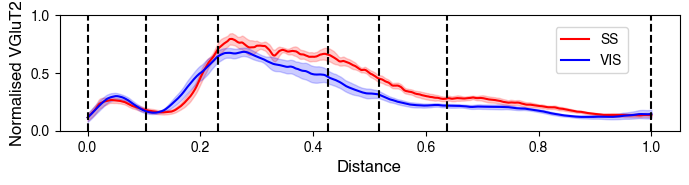

In [118]:
# Min-max
pal = sns.color_palette(['red','blue'])
fig = plt.figure(figsize=(8,1.5))
ax = fig.add_subplot(111)
sns.lineplot(x='norm_Distance',y='min-max_VGLUT2',hue='Area',palette=pal,errorbar='se',data=new_interpolated_df,ax=ax)
ax.set_ylabel('Normalised VGluT2',size=12)
ax.set_xlabel('Distance',size=12)
ax.legend(loc=(0.8,0.5))
ax.set_yticks(np.linspace(0,1,3))
ax.axvline(x = mean_normed_markers[0],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[1],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[2],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[3],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[4],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[5],ymax = 1,color='k',linestyle='--')
ax.axvline(x = mean_normed_markers[6],ymax = 1,color='k',linestyle='--')
# plt.savefig("./s26_FTD_min-max_VGLUT2.svg",dpi=300,format='svg',bbox_inches='tight')

In [28]:
# Just checking. 
mean_normed_markers

[0.0, 0.104, 0.232, 0.427, 0.516, 0.637, 1.0]

### Calculate the middle n percent of values at each interval

In [85]:
result_middle_40 = new_interpolated_df.groupby(['Sample_ID','Intervals','Area'])['min-max_VGLUT2'].apply(mean_of_middle_n_percent, 20).reset_index()
result_middle_40

,Sample_ID,Intervals,Area,min-max_VGLUT2
0,986AP25S24SS,Interval 1,SS,0.210038
1,986AP25S24SS,Interval 2,SS,0.251163
2,986AP25S24SS,Interval 3,SS,0.451623
3,986AP25S24SS,Interval 4,SS,0.492724
4,986AP25S24SS,Interval 5,SS,0.354942
5,986AP25S24SS,Interval 6,SS,0.274318
6,986AP25S24VIS,Interval 1,VIS,0.117202
7,986AP25S24VIS,Interval 2,VIS,0.114747
8,986AP25S24VIS,Interval 3,VIS,0.256321
9,986AP25S24VIS,Interval 4,VIS,0.170160


In [86]:
result_middle_40.groupby(["Intervals","Area"]).mean()

/var/folders/p3/5y_1bf5d18qb6cs03qnm3dv80000gr/T/ipykernel_53053/4109693214.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_middle_40.groupby(["Intervals","Area"]).mean()


min-max_VGLUT2
Intervals  Area                
Interval 1 SS          0.228976
           VIS         0.159217
Interval 2 SS          0.260874
           VIS         0.174749
Interval 3 SS          0.547228
           VIS         0.350086
Interval 4 SS          0.594287
           VIS         0.319849
Interval 5 SS          0.370187
           VIS         0.199615
Interval 6 SS          0.256583
           VIS         0.155202